<a href="https://colab.research.google.com/github/Avery1493/Tip-Prediction/blob/master/Tip_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tip Prediction
The purpose of this project is to build a preditive model to estimate the total amount of tips you would earn each day as a delivery driver. I worked at Domino's for over 2 years and used personal data I collected during that time. 

In [255]:
# Import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load in data
tips = pd.read_csv('https://raw.githubusercontent.com/Avery1493/Tip-Prediction/master/Data/Tips.csv')
weather = pd.read_csv('https://raw.githubusercontent.com/Avery1493/Tip-Prediction/master/Data/weather.csv')

# Look at tips dataset
print(tips.shape)
tips.sample(3)

(423, 8)


,Week,Day of Week,Date,Take Home,Tips,Mileage,Miles,Hours
291,47,Monday,11/19/2018,145.85,119.66,26.19,97,8.0
88,45,Friday,11/10/2017,26.77,19.07,7.70,35,4.0
96,48,Friday,12/1/2017,45.13,35.45,9.68,44,5.0


In [256]:
# Look at weather dataset
print(weather.shape)
weather.sample(3)

(1090, 2)


,DATE,PRCP
39,2/9/2017,0.11
984,9/17/2019,0.00
446,3/25/2018,0.17


In [257]:
# Wrangling Data

# TIPS DATA SET
# Convert 'Date' to datetime
# Add 4 columns : 'Year', 'Month', 'Day', and replace 'Day of Week'
tips['Date'] = pd.to_datetime(tips['Date'])
tips['Year'] = tips['Date'].dt.year
tips['Month'] = tips['Date'].dt.month
tips['Day'] = tips['Date'].dt.day
tips['Day of Week'] = tips['Date'].dt.dayofweek

# Add new column: average miles driven each hour
tips['Miles per Hour'] = tips['Miles'] / tips['Hours']

# Create new categorical column: capture daily business demand
# IQR will be normal (anything below or above is slow/busy)
a = np.array(tips['Miles per Hour'])
s, n, b = np.quantile(a,[.25,.5,.75])

tips.loc[tips['Miles per Hour'] < s, 'Demand'] = 'Slow'
tips.loc[tips['Miles per Hour'] > s, 'Demand'] = 'Normal'
tips.loc[tips['Miles per Hour'] > b, 'Demand'] = 'Busy'


# WEATHER DATA SET
# Convert 'DATE' to datetime
# Change column name to match with tips data set
weather['Date'] = pd.to_datetime(weather['DATE'])
weather = weather.drop(columns='DATE')


# MERGING DATA SETS
# Merge on left so only dates from tips data set are retained 
df = pd.merge(tips,weather, on='Date', how='left')

# Combined dataset
print(df.shape)
df.sample(5)

(423, 14)


,Week,Day of Week,Date,Take Home,Tips,Mileage,Miles,Hours,Year,Month,Day,Miles per Hour,Demand,PRCP
298,48,2,2018-11-28,41.00,31.55,9.45,35,4.0,2018,11,28,8.750000,Normal,0.00
385,13,3,2019-03-28,39.44,28.64,10.80,40,3.0,2019,3,28,13.333333,Busy,0.00
194,20,3,2018-05-17,58.39,43.65,14.74,76,8.0,2018,5,17,9.500000,Normal,0.49
396,15,6,2019-04-14,106.73,86.29,20.44,73,5.0,2019,4,14,14.600000,Busy,1.80
52,36,4,2017-09-08,70.00,55.92,14.08,64,8.0,2017,9,8,8.000000,Slow,0.00


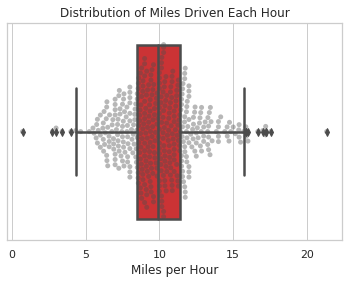

In [258]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x=df['Miles per Hour'],color=".30", alpha=.40)
ax = sns.boxplot(x=df['Miles per Hour'],
            palette="Set1",linewidth=2.5).set_title('Distribution of Miles Driven Each Hour')
plt.savefig('boxplot')

# Baseline

In [259]:
# TRAIN TEST CUT OFF
# data from 06/2017 to 06/2019
cutoff = '2018-07-01 00:00:00'

train = df[df['Date'] < cutoff]
test = df[df['Date'] >= cutoff]

train.shape, test.shape

((218, 14), (205, 14))

In [0]:
target = 'Tips'
features = ['Day of Week','Hours', 'Year', 'Month', 'Day',
            'PRCP', 'Demand']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [261]:
# BASELINE
from sklearn.metrics import mean_absolute_error

print('BASELINE:',df['Tips'].mean())
y_pred = [df['Tips'].mean() ]* len(df)
y_true = df[target]
print(f'MAE:${round(mean_absolute_error(y_true,y_pred),2)}')


BASELINE: 66.34486997635932
MAE:$24.85


# Linerar Regression

In [262]:
!pip install category_encoders
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer

# Linear Regression
lg_model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LinearRegression()
)

lg_model.fit(X_train,y_train)

y_pred = lg_model.predict(X_train)
print(f'Mean Absolute Error:${round(mean_absolute_error(y_train,y_pred),2)}')

Mean Absolute Error:$11.78


In [263]:
lin = lg_model.named_steps['linearregression']
print('Intercept:',lin.intercept_)
print('Coefficients:')
coefficients = pd.Series(lin.coef_,features)
coefficients

Intercept: 13236.592345662393
Coefficients:


Day of Week     0.143363
Hours          10.752171
Year           -6.575769
Month          -0.897345
Day             0.209858
PRCP            4.899379
Demand         11.877490
dtype: float64

# Random Forest

In [264]:
# RANDONMIZED SEARCH and RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)

# Parameters to tune
param_distributions = { 
    'randomforestregressor__n_estimators': [10, 15, 20], 
    'randomforestregressor__max_depth': [3, 5, 10, 15,20, None], 
    'randomforestregressor__min_samples_leaf': [3, 5, 7, 10], 
}

# Random Search
search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=5, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.5s


Best hyperparameters {'randomforestregressor__n_estimators': 15, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 5}
Cross-validation MAE 13.490091863114293


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.7s finished


In [265]:
# RANDOM FOREST MODEL WITH TUNNED HYPER_PARAMETERS
rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators = 15,
                          max_depth = 3,
                          min_samples_leaf = 3,
                          max_features = None,
                          n_jobs =-1,
                          random_state=42)
)

rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_train)
print(f'Mean Absolute Error:${round(mean_absolute_error(y_train,y_pred),2)}')

Mean Absolute Error:$10.79


# Test Prediction

In [266]:
# Linerar Model Results on Test Data
y_pred = lg_model.predict(X_test)
print(f'Mean Absolute Error:${round(mean_absolute_error(y_test,y_pred),2)}')

Mean Absolute Error:$13.47


In [267]:
# Random Forest Model Results on Test Data
y_pred = rf_model.predict(X_test)
print(f'Mean Absolute Error:${round(mean_absolute_error(y_test,y_pred),2)}')

Mean Absolute Error:$18.69


# Shap Plot with Random Forest

In [268]:
# Random Forest Pipeline
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
)

# RF Model
X_train_transformed = transformers.fit_transform(X_train)

rf = RandomForestRegressor(n_estimators = 15,
                          max_depth = 3,
                          min_samples_leaf = 3,
                          max_features = None,
                          n_jobs =-1,
                          random_state=42)

# Fitting Model
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict(X_train_transformed)
mean_absolute_error(y_train,y_pred)

10.788884498290694

In [269]:
!pip install shap
import shap
# Use transformed dataframe
X = pd.DataFrame(X_train_transformed)
# ROW we wan to predict with rf model
row = X.iloc[[81]]
# True Value for row
print('Ture Value:',y_train.iloc[[81]])
row

Ture Value: 81    50.35
Name: Tips, dtype: float64


,0,1,2,3,4,5,6
81,5.0,5.5,2017.0,10.0,28.0,0.01,3.0


In [270]:
# FUNCTION to guess any row (rf model)
def predict(Day_of_Week, Hours,	Year,	Month,	Day,	PRCP,	Demand):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[Day_of_Week, Hours,	Year,	Month,	Day,	PRCP,	Demand]], 
        columns=['Day of Week', 'Hours',	'Year',
                 'Month',	'Day',	'PRCP',	'Demand']
    )

    # Get the model's prediction
    pred = rf.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    print(f'Estimated tips: ${pred:,.0f}')
    print(f'Starting from a base value of: ${explainer.expected_value[0]:,.0f}')
    print(shaps.to_string())   

    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict(5.0,	5.5,	2017.0,	10.0,	28.0,	0.01,	3) #row 81


Estimated tips: $55
Starting from a base value of: $58
(Day of Week, 5.0)   -0.110938
(Hours, 5.5)         -7.372472
(Year, 2017.0)        0.000000
(Month, 10.0)        -0.996631
(Day, 28.0)          -0.171588
(PRCP, 0.01)         -0.031930
(Demand, 3.0)         5.153877


In [271]:
# Linear Equation Row 81
Day_of_Week =  5
Hours = 5.5	
Year = 2017
Month =	10
Day = 28
PRCP = 0.01
Demand = 3 

(lin.coef_[0]*Day_of_Week) + (lin.coef_[1]*Hours) + (lin.coef_[2]*Year) + (lin.coef_[3]*Month) + (lin.coef_[4]*Day) + (lin.coef_[5]*PRCP) + (lin.coef_[6]*Demand) + lin.intercept_

65.70345326144525

In [272]:
# Function to guess any row (lg model)
def tip_prediction(Day_of_Week, Hours,	Year,	Month,	Day,	PRCP,	Demand):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[Day_of_Week, Hours,	Year,	Month,	Day,	PRCP,	Demand]], 
        columns=['Day of Week', 'Hours',	'Year',
                 'Month',	'Day',	'PRCP',	'Demand']
    )

    # Get the model's prediction
    pred = lg_model.predict(df)[0]
    return pred

# Get the model's prediction
tip_prediction(5.0,	5.5,	2017.0,	10.0,	28.0,	0.01,	'Busy') # Row 81

65.70345326144525

# FINAL MODEL ON WHOLE DATA

In [273]:
# Combine train and test
X = pd.concat([train,test])
print(X.shape)
X.sample(3)

(423, 14)


,Week,Day of Week,Date,Take Home,Tips,Mileage,Miles,Hours,Year,Month,Day,Miles per Hour,Demand,PRCP
185,18,3,2018-05-03,63.00,45.62,17.38,79,7.0,2018,5,3,11.285714,Normal,0.00
57,37,5,2017-09-16,82.00,67.26,14.74,67,7.0,2017,9,16,9.571429,Normal,0.01
166,12,6,2018-03-25,68.84,53.22,15.62,71,7.0,2018,3,25,10.142857,Normal,0.17


In [274]:
target = 'Tips'
features = ['Day of Week','Hours', 'Year', 'Month', 'Day',
            'PRCP', 'Demand']
y_train = X[target]
X_train = X[features]
X_train.shape, y_train.shape

((423, 7), (423,))

In [275]:
# Linear Regression
# Final model trained on entire data set

lg_model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LinearRegression()
)

lg_model.fit(X_train,y_train)

y_pred = lg_model.predict(X_train)
print(f'Mean Absolute Error:${round(mean_absolute_error(y_train,y_pred),2)}')

# Pickle the pipeline 
from joblib import dump
dump(rf_model, 'lg.joblib', compress=True)

Mean Absolute Error:$12.61


['lg.joblib']

In [276]:
# Model Intercept and Coefficients
lg = lg_model.named_steps['linearregression']
print('Intercept:',lg.intercept_)
print('Coefficients:')
coefficients = pd.Series(lg.coef_,features)
coefficients

Intercept: 7958.3635558502165
Coefficients:


Day of Week     0.250519
Hours          10.410788
Year           -3.960909
Month          -0.683721
Day             0.180317
PRCP            2.180254
Demand         14.040265
dtype: float64

# Permutation Importances

In [277]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

# Pipeline
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
)

# Model
X_train_transformed = transformers.fit_transform(X_train)

lg = LinearRegression()

# Fitting Model
lg.fit(X_train_transformed, y_train)
y_pred = lg.predict(X_train_transformed)
mean_absolute_error(y_train,y_pred)

12.605957811566167

In [278]:
permuter = PermutationImportance(
    lg, 
    scoring='neg_mean_absolute_error', 
    n_iter=10, 
    random_state=42
)

permuter.fit(X_train_transformed, y_train)


feature_names = X_train.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names 
)



Weight,Feature
18.0489 ± 1.5597,Hours
4.2406 ± 0.8035,Demand
0.3770 ± 0.3536,Year
0.3432 ± 0.2323,Month
0.1292 ± 0.2281,Day
0.0590 ± 0.0747,PRCP
-0.0123 ± 0.0353,Day of Week


# PDP

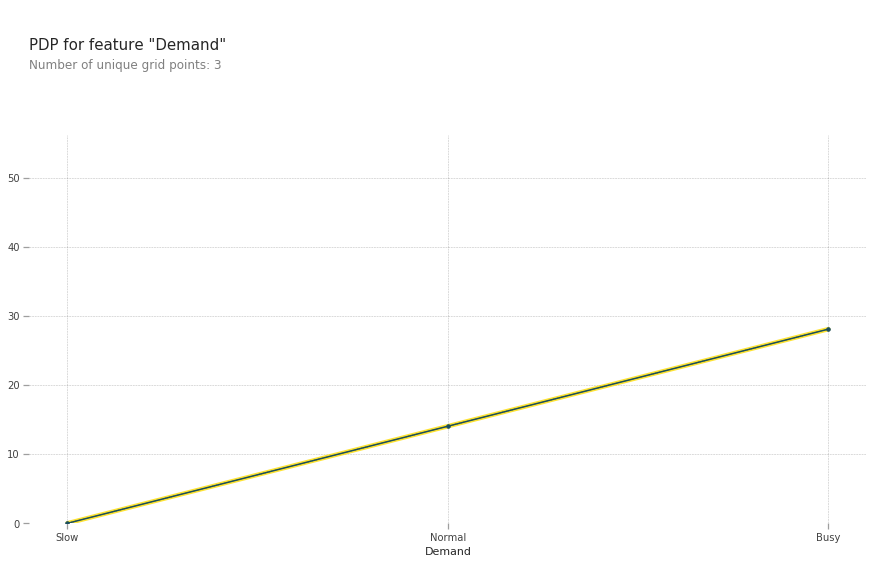

In [279]:
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot

#Creating new dataframe with 
X = pd.DataFrame(X_train_transformed)
X.columns = ['Day of Week','Hours', 'Year', 'Month', 'Day',
            'PRCP', 'Demand']

feature = 'Demand'

isolated = pdp_isolate(
    model = lg,
    dataset = X,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated,feature_name=feature,plot_lines=.9)
plt.xticks([1, 2,3], ['Slow', 'Normal', 'Busy']);

Text(0.5, 0, 'Precipitation (inches)')

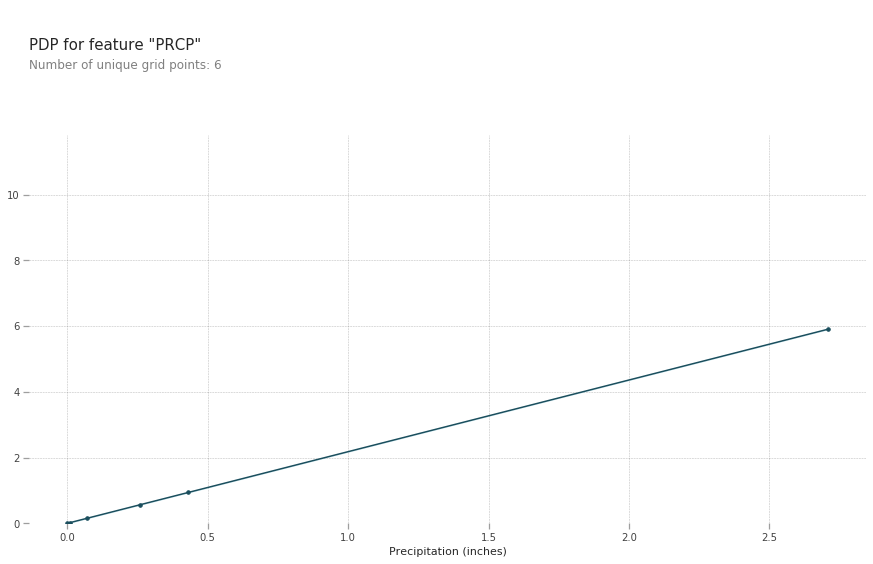

In [280]:
feature = 'PRCP'

isolated = pdp_isolate(
    model = lg,
    dataset = X,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated,feature_name=feature);
plt.xlabel('Precipitation (inches)')

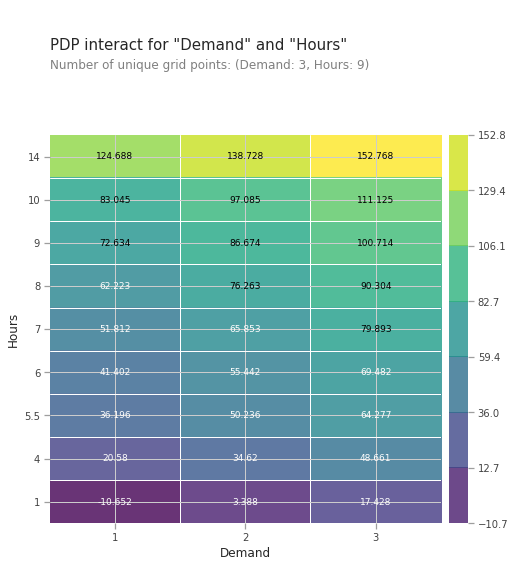

In [281]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Demand','Hours']

interaction = pdp_interact(
    model = lg,
    dataset = X,
    model_features= X_train.columns,
    features = features
)

pdp_interact_plot(interaction, feature_names=features, plot_type='grid');

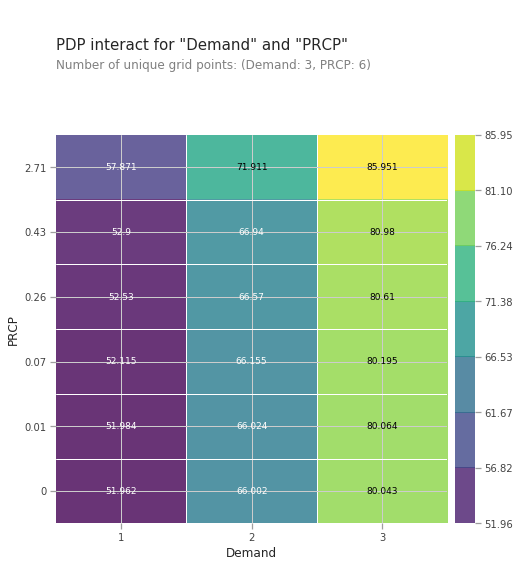

In [282]:
features = ['Demand','PRCP']

interaction = pdp_interact(
    model = lg,
    dataset = X,
    model_features= X_train.columns,
    features = features
)

pdp_interact_plot(interaction, feature_names=features, plot_type='grid');